# International Hedging Cost

In [27]:
import numpy as np
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt

# Read in and collect data

In [3]:
df_raw = pd.read_parquet("08_03_fx_hc.parquet")

datetime.date(2010, 1, 1)

In [32]:
df_fred = web.DataReader(
    "DGS10", 
    data_source = "fred",
    start = df_raw.date.min().date(),
    end = df_raw.date.max().date())

In [33]:
df_fred

,DGS10
DATE,
2010-01-01,NaN
2010-01-04,3.85
2010-01-05,3.77
2010-01-06,3.85
2010-01-07,3.85
...,...
2023-07-25,3.91
2023-07-26,3.86
2023-07-27,4.01


# Background

We can first start by looking at flow of funds going into fixed income. The data comes from estimates provided from the US Treasury and is lagged by 2 months

In [18]:
df_jp_holding = (df_raw.query(
    "ticker == ['HOLDJN Index', 'USLTREP Index']").
    dropna().
    drop(columns = ["field"]).
    pivot(index = "date", columns = "ticker", values = "value").
    rename(columns = {"HOLDJN Index": "Japanese Holdings"}))

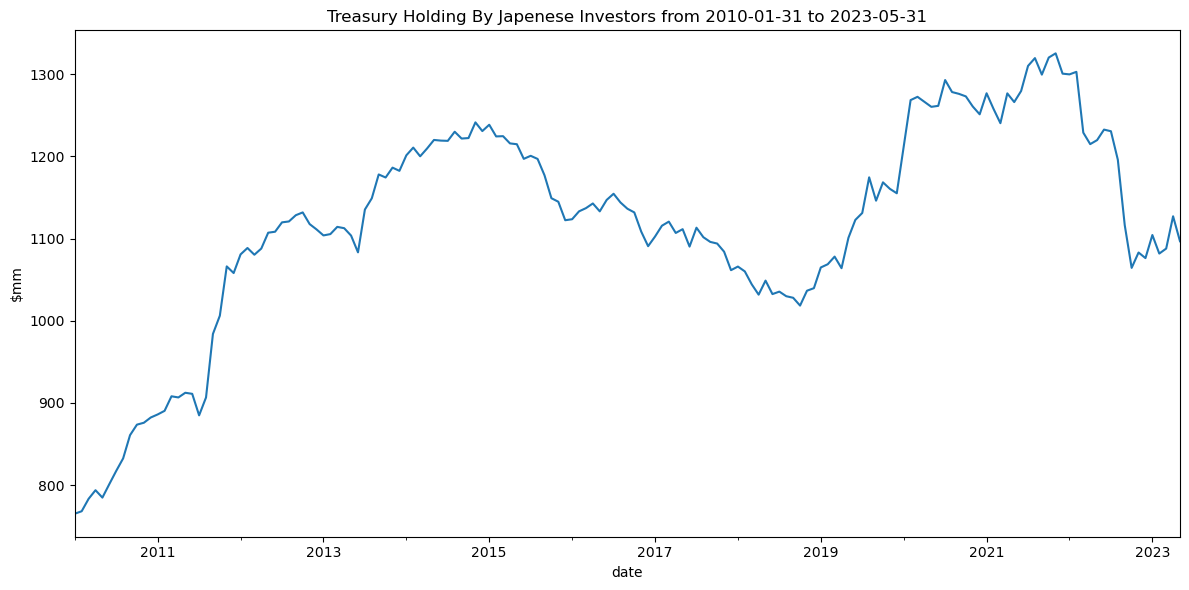

In [23]:
df_jp_holding.plot(
    figsize = (12, 6),
    legend = False,
    ylabel = "$mm",
    title = "Treasury Holding By Japenese Investors from {} to {}".format(
        df_jp_holding.index.min().date(),
        df_jp_holding.index.max().date()))

plt.tight_layout()
plt.show()

Let's look at three options an investor would have <br> 1. By Japenese Securities <br> 2. Buy US Treasury <br> 3. Buy FX Hedged US Treasuries

In [25]:
(df_raw.ticker.drop_duplicates())

0        USLTTREP Index
3591     GECU10YR Index
7182     FXHCUJ12 Index
10773    FXHCUE1M Index
14364    FXHCUE12 Index
17955    FXHCUE6M Index
21546    FXHCUJ1M Index
25137    FXHCUJ6M Index
28728    FXHCUJ2Y Index
32319    FXHCUJ18 Index
35910      GJGB10 Index
39501      HOLDJN Index
43092    FXHCUJ3Y Index
Name: ticker, dtype: object

In [47]:
df_jpy_yield = (df_raw.query(
    "ticker == 'GJGB10 Index'").
    drop(columns = ["field"]).
    assign(ticker = lambda x: x.ticker.str.split(" ").str[0]).
    pivot(index = "date", columns = "ticker", values = "value").
    reset_index())

In [48]:
df_jp_hc = (df_raw.assign(
    letter = lambda x: x.ticker.str[5]).
    query("letter == 'J'").
    drop(columns = ["field", "letter"]).
    assign(ticker = lambda x: x.ticker.str.split(" ").str[0]).
    pivot(index = "date", columns = "ticker", values = "value").
    reset_index())

In [49]:
df_tsy = (df_fred.reset_index().rename(columns = {"DATE": "date"}))

In [76]:
df_hedge_name = pd.DataFrame({
    "ticker": ["FXHCUSJ12", "FXHUCJ1M", "FXHCUJ18", "FXHCUJ2Y", "FXHCUJ3Y", "FXHCUJ6M"],
    "Hedged Position": ["12m Hedged", "1m Hedged", "18m Hedged", "2y Hedged", "3y Hedged", "6m Hedged"]})

In [83]:
df_hedged_tsy = (df_jp_hc.melt(
    id_vars = "date").
    merge(df_tsy, how = "inner", on = ["date"]).
    dropna().
    assign(hedged_ten_yr = lambda x: x.DGS10 - x.value).
    merge(df_hedge_name, how = "inner", on = ["ticker"])
    [["date", "Hedged Position", "hedged_ten_yr"]].
    pivot(index = "date", columns = "Hedged Position", values = "hedged_ten_yr"))

In [90]:
df_combined = (df_jpy_yield.merge(
    df_hedged_tsy, how = "inner", on = ["date"]).
    rename(columns = {"GJGB10": "JPY Yield"}).
    merge(df_tsy, how = "inner", on = ["date"]).
    rename(columns = {"DGS10": "10y Treasury"}).
    set_index("date"))

In [121]:
col_color = {
    "JPY Yield": "orangered",
    "18m Hedged": "grey",
    "12m Hedged": "grey",
    "2y Hedged": "grey",
    "3y Hedged": "grey",
    "6m Hedged": "grey",
    "10y Treasury": "navy"}

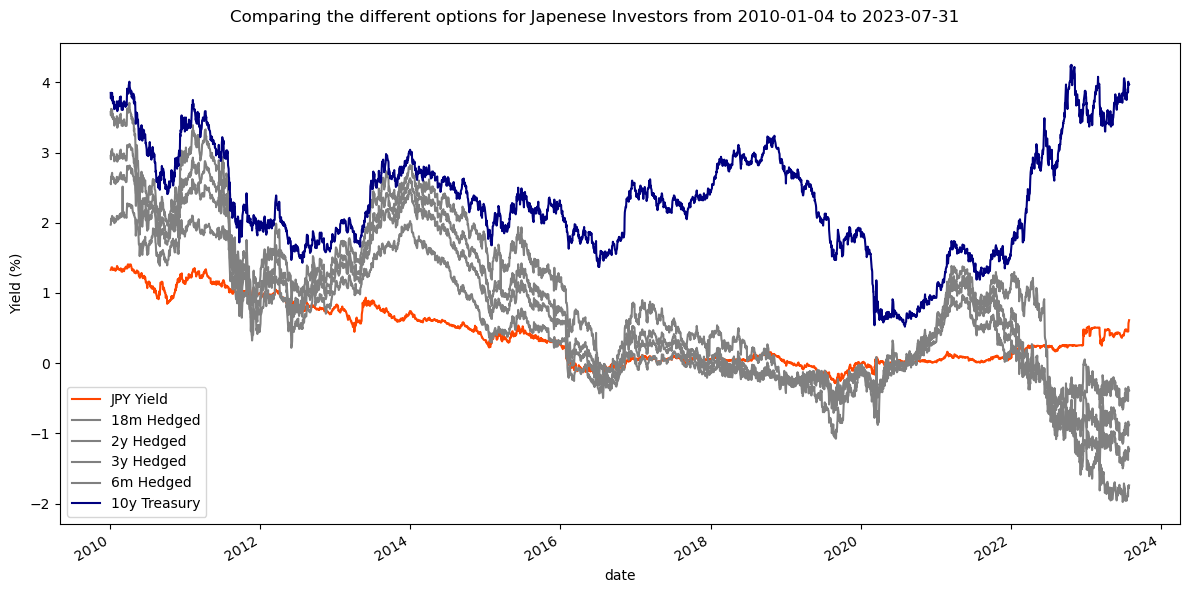

In [124]:
(df_combined.plot(
    figsize = (12, 6),
    ylabel = "Yield (%)",
    color = col_color))

plt.suptitle("Comparing the different options for Japenese Investors from {} to {}".format(
    df_combined.index.min().date(),
    df_combined.index.max().date()))

plt.tight_layout()
plt.show()

Let's analyze what the returns differential is between the domestic sovereign rate and all of our options

In [128]:
df_comparison = (df_combined.drop(
    columns = ["JPY Yield"]).
    reset_index().
    melt(id_vars = "date").
    merge(
        (df_combined[
            ["JPY Yield"]].
            reset_index().
            melt(id_vars = "date").
            rename(columns = {
                "variable": "jpy_ticker",
                "value": "jpy_yield"})),
        how = "inner",
        on = ["date"]))

In [136]:
df_comparison.head(3)

,date,variable,value,jpy_ticker,jpy_yield
0,2010-01-04,18m Hedged,2.9528,JPY Yield,1.329
1,2010-01-04,2y Hedged,2.5637,JPY Yield,1.329
2,2010-01-04,3y Hedged,1.9727,JPY Yield,1.329


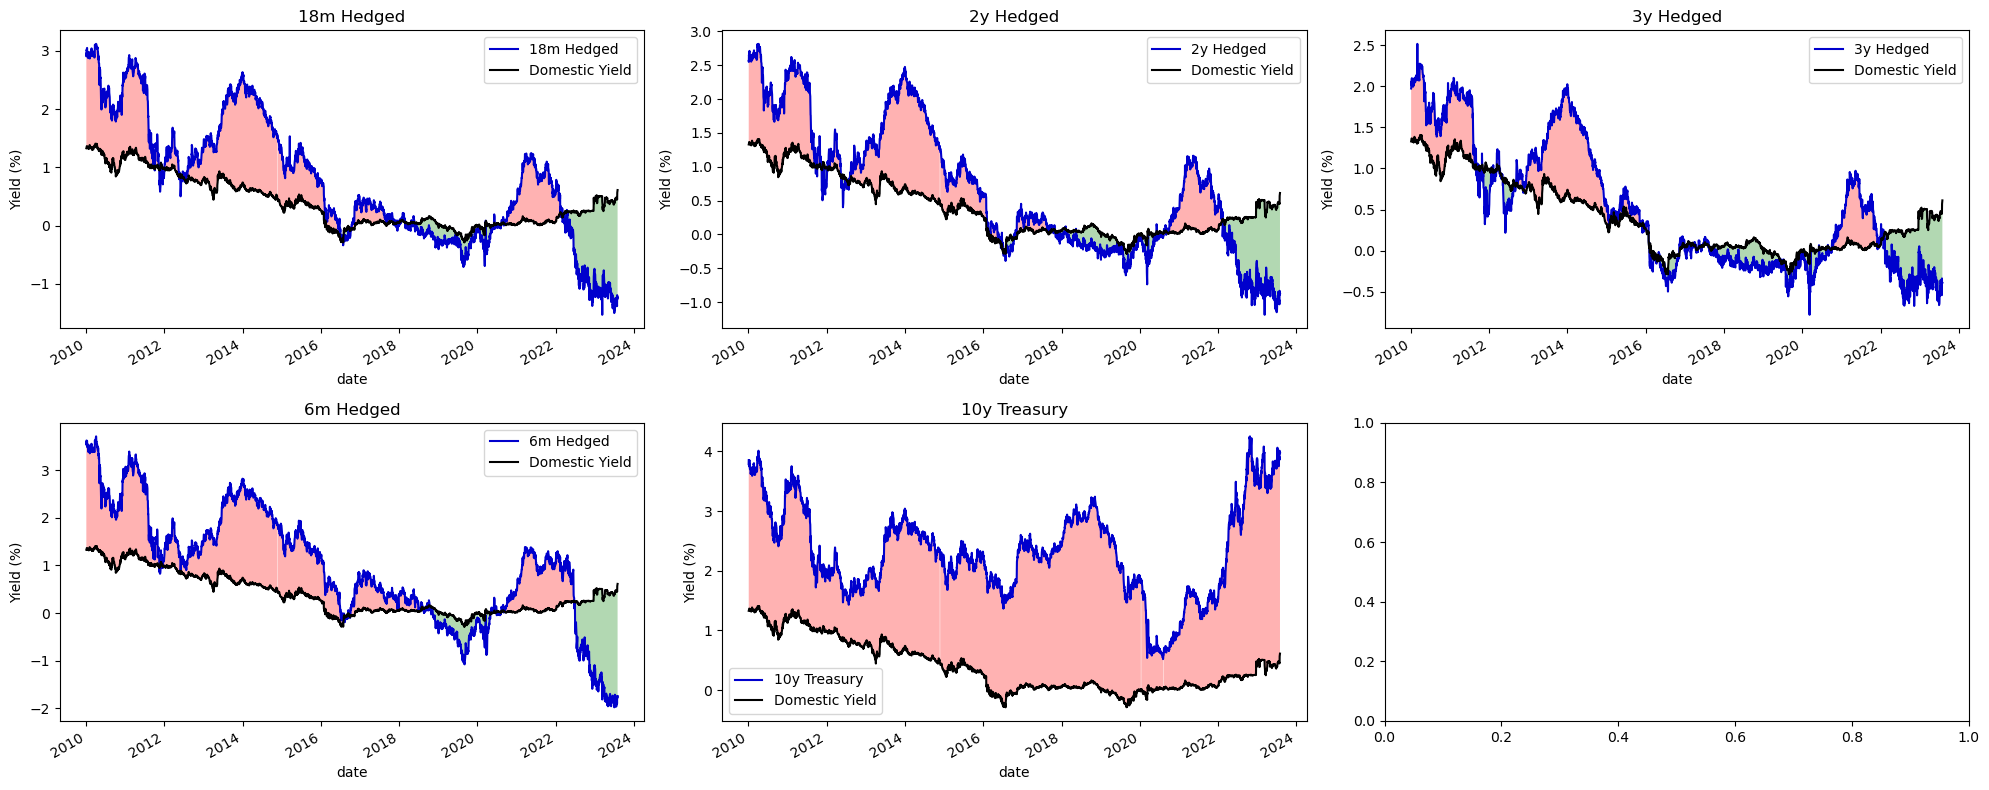

In [169]:
fig, axes = plt.subplots(ncols = 3, nrows = 2, figsize = (20, 8))

i, j = 0,0
for ticker in df_comparison.variable.drop_duplicates().to_list():
    
    df_tmp = (df_comparison.query(
        "variable == @ticker"))
    
    col_name = df_tmp.variable.iloc[0]
    
    (df_tmp.set_index(
        "date")
        [["value", "jpy_yield"]].
        rename(columns = {
            "value": col_name,
            "jpy_yield": "Domestic Yield"}).
        plot(
            ax = axes[i,j],
            color = ["mediumblue", "black"],
            ylabel = "Yield (%)",
            title = col_name))
    
    axes[i,j].fill_between(
        x = df_tmp.date.drop_duplicates(),
        y1 = df_tmp.jpy_yield,
        y2 = df_tmp.value,
        where = df_tmp.jpy_yield > df_tmp.value,
        facecolor = "green",
        alpha = 0.3)
    
    axes[i,j].fill_between(
        x = df_tmp.date.drop_duplicates(),
        y1 = df_tmp.jpy_yield,
        y2 = df_tmp.value,
        where = df_tmp.jpy_yield < df_tmp.value,
        facecolor = "red",
        alpha = 0.3)
    
    if j == 2:
        j = 0
        i += 1
        
    else: j += 1
    
plt.tight_layout()
plt.show()